In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls

: 

In [ ]:
import Foundation
import TensorFlow
import FastaiNotebook_10_mixup_ls
import Path

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

## Loading the data

Luckily, TensorFlow has a "decodeWav" function. Let's extend the StringTensor to provide swifty access to this function, the same way we did with JPGs.

In [ ]:
public extension StringTensor {
    // Decode a StringTensor holding a path to a WAV file into (audio: Tensor<Float>, sampleRate: Tensor<Int32>)
    func decodeWav() -> (audio: Tensor<Float>, sampleRate: Tensor<Int32>) {
        return Raw.decodeWav(contents: self)
    }
}

### Single example file

In [ ]:
let wav_file = "m0005_us_m0005_00445.wav"

In [ ]:
let (sig, sr) = StringTensor(readFile: wav_file).decodeWav()

In [ ]:
let dest_len = sr * 3
// print(sig,sr,dest_len)
// print(dest_len.scalar!)
sig.shape

// print(type(of: dest_len), dest_len.shape, dest_len)
// sig.slice(lowerBounds: Tensor(0).expandingShape(at: 0), sizes: dest_len.expandingShape(at: 0))

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 40320
    - 1 : 1


### To Spectrogram

In [ ]:
let spec = Raw.audioSpectrogram(sig, 
                                windowSize: 1024, stride: 256, magnitudeSquared: false)

In [ ]:
func showSpec(s: Tensor<Float>) {
    plt.imshow(s.makeNumpyArray()[0], cmap: "plasma")
    plt.show()
    print("Shape: \(s.shape)\nMin:\(s.min()), max: \(s.max()), mean: \(s.mean()), var: \(s.variance())")
}

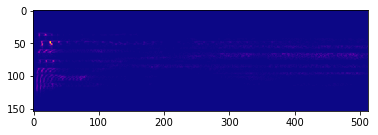

Shape: TensorShape(dimensions: [1, 154, 513])
Min:4.9222303e-06, max: 24.352493, mean: 0.12011659, var: 0.1986352


In [ ]:
showSpec(s: spec)

### To MFCCs

Note that MFCCs are different from melspectrograms. It seems TF doesn't have a melspectrogram transform built-in. MFCCs at least have been used before so it doesn't seem crazy to use them instead, although they are generally used to intentionally reduce the dimensionality of the data, so we might be throwing away info that the NN could use. On the other hand we might be making it easier for the NN to find features it would've had to spend time finding itself. We'll give it a shot. On the plus side, it means much "smaller images".

[TF defaults](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/ops/audio_ops.cc#L147) for MFCCs:
```
    .Attr("upper_frequency_limit: float = 4000")
    .Attr("lower_frequency_limit: float = 20")
    .Attr("filterbank_channel_count: int = 40")
    .Attr("dct_coefficient_count: int = 13")
```

In [ ]:
let mfccs = Raw.mfcc(spectrogram: spec, sampleRate: sr, 
                       upperFrequencyLimit: 8000, lowerFrequencyLimit: 20, 
                       filterbankChannelCount: 40, dctCoefficientCount: 13)

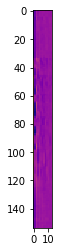

Shape: TensorShape(dimensions: [1, 154, 13])
Min:-7.5308914, max: 15.715063, mean: 0.08064073, var: 6.4020457


In [ ]:
showSpec(s: mfccs)

### Loading all the sample data

In [ ]:
// hardcoded way
//export
public func downloadSpeakers(path: Path = dataPath) -> Path {
    let url = "http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz"
    let fname = "ST-AEDS-20180100_1-OS"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = shellCommand("/bin/tar", ["-xzf", (path/"\(fname).tgz").string, "-C", path.string])
    }
    return file
}

In [ ]:
let path = downloadSpeakers()

In [ ]:
for e in path.ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00068.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00134.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00311.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00019.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00250.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00318.wav (file)
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00390.wav (file)
/home/jupyter/.fastai/data/S

In [ ]:
var wav = path.ls()[0].path
print(type(of: wav))

Path


In [ ]:
let il = ItemList(fromFolder: path, extensions: ["wav", "WAV"])

In [ ]:
print(il)

ItemList<Path>(items: [Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00068.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00192.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00356.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00355.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00134.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00311.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00019.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00250.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00318.wav), Path(/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00390.wav), Path(

In [ ]:
public func randomSplitter(fName: Path, val_pct: Float) -> Bool {
    return Float.random(in: 0.0...1.0) < val_pct
}

In [ ]:
let sd = SplitData(il) { randomSplitter(fName: $0, val_pct: 0.2) }

In [ ]:
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())

We need a RegexLabeler. In python this was
```python
def re_labeler(fn, pat): return re.findall(pat, str(fn))[0]
```

In [ ]:
public func reLabeler(_ fName: Path, pat: String) -> String {
    // Gotta slice the input using the found range, then cast that `Substring` to `String`
    // Seems too clunky to be true but it does work
    // Needs a guard if re doesn't match
    return String(fName.string[fName.string.findFirst(pat: pat)!])
}

In [ ]:
let pat = "[mf]\\d+"

In [ ]:
print(reLabeler(wav, pat: pat))

m0002


In [ ]:
// Surely this isn't how I'm supposed to do a 'partial' in Swift??
// Only doing it because I couldn't get SplitLabeledData to work with a 2-arg fromFunc
func speakerLabeler (item: Path) -> String {
    return reLabeler(item, pat: pat)
}

In [ ]:
print(speakerLabeler(item: wav))

m0002


In [ ]:
let sld = SplitLabeledData(sd, fromFunc: speakerLabeler, procItem: &procItem, procLabel: &procLabel)

In [ ]:
// What did that do?
print(type(of: sld.train.items[0]),":", sld.train.items[0])
print(type(of: sld.train.labels[0]),":", sld.train.labels[0])
print(type(of: sld.train.rawLabel(0)),":", sld.train.rawLabel(0))
print(type(of: sld.train.procLabel.vocab!),":", sld.train.procLabel.vocab!)

Path : /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00093.wav
Int32 : 6
String : m0002
Array<String> : ["f0001", "f0002", "f0003", "f0004", "f0005", "m0001", "m0002", "m0003", "m0004", "m0005"]


In [ ]:
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 64)

In [ ]:
print(rawData.train.oneBatch())

Optional(FastaiNotebook_10_mixup_ls.LabeledElement<TensorFlow.StringTensor, TensorFlow.Tensor<Swift.Int32>>(xb: TensorFlow.StringTensor(handle: TensorFlow.TensorHandle<Swift.String>), yb: [4, 2, 3, 4, 0, 3, 2, 0, 2, 9, 9, 5, 1, 9, 7, 6, 7, 0, 6, 4, 9, 1, 9, 1, 8, 7, 0, 9, 0, 9, 6, 4, 4, 9, 0, 1, 4, 6, 6, 5, 5, 7, 3, 3, 1, 4, 2, 7, 9, 4, 1, 3, 4, 1, 1, 7, 9, 9, 7, 2, 8, 3, 5, 6]))


Note that the `xb` is full of `StringTensor`s, not `FloatTensors` - that's because we've got to load them into first WAVs, then spectrograms.

Lazy hardcoded args.

In [ ]:
public func openAndSpectro(fname: StringTensor) -> TF{
    let (sig,sr) = StringTensor(readFile: fname).decodeWav()
    let spec = Raw.audioSpectrogram(sig, 
                                windowSize: 1024, stride: 256, magnitudeSquared: false)
    return spec
}

In [ ]:
let data = transformData(rawData, tfmItem: { openAndSpectro(fname: $0) })

In [ ]:
// let batch = data.train.oneBatch()!

So that didn't work because they're all different sizes i.e. the WAVs are different lengths. We could make this easier on ourselves by pre-processing in a different notebook/step, but let's trim the tensors to a given length after we load them.

I'm not clear on whether this ought to be done as a Processor or a Transform. Here, I'll do it in a Transform, because I'm confused by the Processor - particularly the `deprocess` methods.

In [ ]:
// public func openAndSpectro(fname: StringTensor) -> TF{
//     let (sig,sr) = StringTensor(readFile: fname).decodeWav()
//     let shortSig = sig[..<16000]
//     let spec = Raw.audioSpectrogram(shortSig, 
//                                 windowSize: 1024, stride: 256, magnitudeSquared: false)
//     return spec
// }

In [ ]:
// print(batch.xb.shape)
// print(batch.yb.shape)
// let labels = batch.yb.scalars.map { procLabel.vocab![Int($0)] }
// showImages(batch.xb, labels: labels)

In [ ]:
let data = transformData(rawData, tfmItem: { openAndSpectro(fname: $0) })

In [ ]:
let batch = data.train.oneBatch()!

In [ ]:
// export
public func showSpecs(_ xb: TF, labels: [String]? = nil) {
    let (rows,cols) = (3,3)
//     plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x[0])
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.tight_layout()
    plt.show()
}

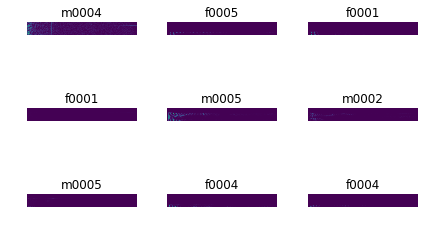

In [ ]:
let labels = batch.yb.scalars.map { sld.train.procLabel.vocab![Int($0)] }
showSpecs(batch.xb, labels: labels)

#### Deal with this generic downloader & unzipper later

In [ ]:
let fname = "ST-AEDS-20180100_1-OS"
let fext = "tgz"
let url = "http://www.openslr.org/resources/45/\(fname).\(fext)"
print(url)

In [ ]:
//export
public func downloadURL(url: String, 
                        dest_path: Path = dataPath, 
                        dest_dirname: String, 
                        fext: String="tgz") -> Path {
//     let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
//     let fname = "imagenette-160"
    let file = dest_path/Path(dest_dirname)
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = shellCommand("/bin/tar", ["-xzf", (path/"\(fname).tgz").string, "-C", path.string])
    }
    return file
}